In [6]:
import csv

# Load the dataset
col_names = []
dataset = [[], [], [], [], [], [], []]  # 7 columns
with open('GLT_filtered.csv') as fp:
    reader = csv.reader(fp)
    col_names = next(reader)  # Get column names
    for cols in reader:
        if len(cols) == len(col_names):  # Only process complete rows
            for i in range(len(dataset)):
                dataset[i].append(cols[i])

# Print some rows for verification
for i in range(4):  # Print first 4 rows
    for j in range(len(dataset)):
        print(f'{dataset[j][i]} ', end='')
    print('')


1849-01-01 26.704 1.435 Abidjan Côte D'Ivoire 5.63N 3.23W 
1849-02-01 27.434 1.3619999999999999 Abidjan Côte D'Ivoire 5.63N 3.23W 
1849-03-01   Abidjan Côte D'Ivoire 5.63N 3.23W 
1849-04-01 26.14 1.3869999999999998 Abidjan Côte D'Ivoire 5.63N 3.23W 


In [7]:
def fill_gaps(data, cities):
    right_i = 0
    right_v = 0
    for i, value in enumerate(data):
        if i == 0 or cities[i] != cities[i-1]:
            left_v = 0  # Edge case for first value
        else:
            left_v = data[i-1]
        
        # Reuse right_v for consecutive missing values
        if i < right_i:
            data[i] = (left_v + right_v) / 2
            continue

        if value == '':
            # Find next valid value
            for j in range(i+1, len(data)):
                if cities[j] != cities[i]:
                    right_v = 0
                    break
                elif data[j] != '':
                    right_v = float(data[j])
                    break
            if i == len(data) - 1:  # Edge case for last value
                right_v = 0
            right_i = j
            data[i] = (left_v + right_v) / 2
        else:
            data[i] = float(value)  # Convert to float


In [12]:
# Extract unique cities from the dataset
cities = set(dataset[3])  # dataset[3] contains the list of city names

# Initialize dictionaries for temperatures
city_avg_temp = {}
city_avg_temp_unc = {}

# Populate the dictionaries with average temperatures for each city
for city in cities:
    # Extract the indices where the city matches
    indices = [i for i, c in enumerate(dataset[3]) if c == city]
    
    # Get the average temperatures and uncertainties for those indices
    city_avg_temp[city] = [float(dataset[1][i]) for i in indices if dataset[1][i] != '']  # Filter out missing values
    city_avg_temp_unc[city] = [float(dataset[2][i]) for i in indices if dataset[2][i] != '']  # Filter out missing values


In [13]:
def print_hottest_coolest(city, N, city_avg_temp):
    sorted_temps = sorted(city_avg_temp[city], reverse=True)
    print(f'Top {N} hottest measurements in {city}:', sorted_temps[:N])
    print(f'Top {N} coolest measurements in {city}:', sorted_temps[-N:])


In [14]:
print_hottest_coolest('Rome', 5, city_avg_temp)


Top 5 hottest measurements in Rome: [25.951, 24.998, 24.873, 24.730999999999998, 24.48]
Top 5 coolest measurements in Rome: [-0.7829999999999999, -0.871, -1.0189999999999997, -1.3039999999999994, -1.4410000000000005]


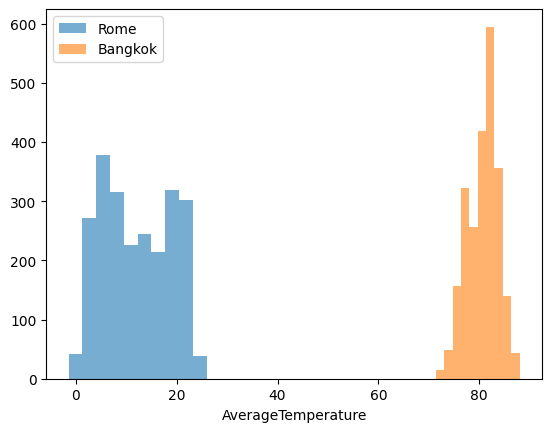

In [15]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

for city in ['Rome', 'Bangkok']:
    plt.hist(city_avg_temp[city], label=city, alpha=0.6)
plt.legend()
plt.xlabel('AverageTemperature')
plt.show()


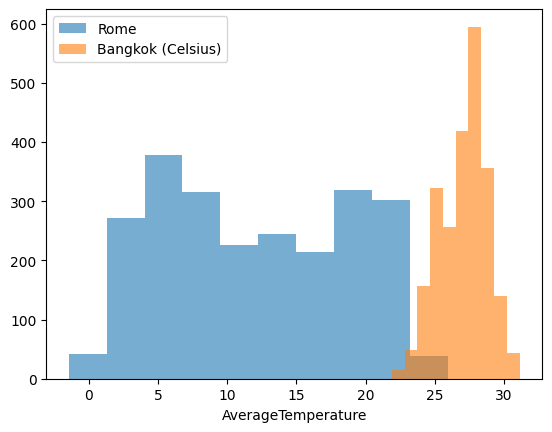

In [16]:
def fah2cel(temp_f):
    return (temp_f - 32) / 1.8

# Convert Bangkok temperatures to Celsius and plot again
bang_celsius = [fah2cel(t) for t in city_avg_temp['Bangkok']]

plt.hist(city_avg_temp['Rome'], label='Rome', alpha=0.6)
plt.hist(bang_celsius, label='Bangkok (Celsius)', alpha=0.6)
plt.legend()
plt.xlabel('AverageTemperature')
plt.show()


Part 2: Textual Data Preparation on IMDb Reviews

In [24]:
# Import necessary libraries
import csv
import string
import math

# Load the IMDb reviews dataset
reviews, labels = [], []
with open('aclimdb_reviews_train.txt', encoding='utf-8') as fp:
    reader = csv.reader(fp)
    next(reader)  # Skip the header
    for row in reader:
        reviews.append(row[0])
        labels.append(row[1])

print(f'Number of reviews: {len(reviews)}')


Number of reviews: 25000


In [25]:
# Tokenization: Remove punctuation and split each review into words
def tokenize(docs):
    tokens = []
    for doc in docs:
        for punct in string.punctuation:
            doc = doc.replace(punct, " ")
        tokens.append([token.lower() for token in doc.split() if token])
    return tokens

# Tokenize the reviews
token_list = tokenize(reviews)


In [26]:
# Compute Term Frequency (TF) for each document
def compute_TF(token_list):
    TF = []
    for doc in token_list:
        tf = {}
        for token in doc:
            tf[token] = tf.get(token, 0) + 1
        TF.append(tf)
    return TF

TF_list = compute_TF(token_list)


In [27]:
# Compute Inverse Document Frequency (IDF)
def compute_IDF(TF_list):
    DF = {}
    N = len(TF_list)
    for tf in TF_list:
        for token in tf:
            DF[token] = DF.get(token, 0) + 1
    return {token: math.log(N / df) for token, df in DF.items()}

IDF_dict = compute_IDF(TF_list)


In [28]:
# Compute TF-IDF for each document
def compute_TFIDF(TF_list, IDF_dict):
    TFIDF = []
    for tf in TF_list:
        tfidf = {token: tf[token] * IDF_dict[token] for token in tf}
        TFIDF.append(tfidf)
    return TFIDF

# Get the TF-IDF vectors for all documents
tf_idf = compute_TFIDF(TF_list, IDF_dict)


In [30]:
# Function to compute L2-norm of a vector
def norm(d):
    return sum([tf_idf**2 for t, tf_idf in d.items() ])**0.5

# Function to compute the dot product between two vectors
def dot_product(d1, d2):
    word_set = set(list(d1.keys()) + list(d2.keys()))
    return sum([(d1.get(d, 0.0) * d2.get(d, 0.0)) for d in word_set])

# Function to compute cosine similarity
def cosine_similarity(d1, d2):
    return dot_product(d1, d2) / (norm(d1) * norm(d2))


In [31]:
# Split TF-IDF vectors into positive and negative groups based on labels
positive_reviews = [tf_idf[i] for i in range(len(labels)) if labels[i] == '1']
negative_reviews = [tf_idf[i] for i in range(len(labels)) if labels[i] == '0']


In [32]:
# Function to compute average similarity of a test document with a group
def avg_similarity_to_group(test_doc, group):
    return sum([cosine_similarity(test_doc, doc) for doc in group]) / len(group)

# Select a test document (e.g., the first one)
test_doc = tf_idf[0]

# Compute average similarity to both positive and negative groups
avg_sim_pos = avg_similarity_to_group(test_doc, positive_reviews)
avg_sim_neg = avg_similarity_to_group(test_doc, negative_reviews)

# Classify the test document
if avg_sim_pos > avg_sim_neg:
    print("The test document is classified as Positive.")
else:
    print("The test document is classified as Negative.")


The test document is classified as Negative.


In [33]:
# Classify multiple test documents
for i in range(5):  # Test first 5 documents
    test_doc = tf_idf[i]
    avg_sim_pos = avg_similarity_to_group(test_doc, positive_reviews)
    avg_sim_neg = avg_similarity_to_group(test_doc, negative_reviews)
    result = "Positive" if avg_sim_pos > avg_sim_neg else "Negative"
    print(f"Document {i+1} is classified as {result}.")


Document 1 is classified as Negative.
Document 2 is classified as Positive.
Document 3 is classified as Positive.
Document 4 is classified as Negative.
Document 5 is classified as Positive.
